In [1]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,json,glob
import torch
from scipy.signal import savgol_filter
from refmotion_manager.motion_loader import RefMotionLoader

In [5]:
# load dataset for demonstration
from test_loader_cfg import ref_motion_cfg
ref_motion_cfg.time_between_frames=0.02
ref_motion_cfg.motion_files=glob.glob(os.getenv("HOME")+"/workspace/lumos_ws/st_gym/third_party/motions/lus2_joint21/pkl/Mma_Kick_fps.pkl")
ref_motion_cfg.motion_files=glob.glob(os.getenv("HOME")+"/workspace/lumos_ws/st_gym/third_party/motions/nix1_joint21/pkl/GBC_dance_op_100_4900_fps30.pkl")
ref_motion_cfg.motion_files=glob.glob(os.getenv("HOME")+"/workspace/lumos_ws/st_gym/third_party/motions/nix1_joint21/pkl/GBC_dance_full_OP_1_5004_fps30.pkl")
ref_motion_cfg.motion_files=os.getenv("HOME")+"/workspace/lumos_ws/st_gym/third_party/motions/nix2/pkl/CMU*web*.pkl"

ref_motion_cfg.device="cpu"
ref_motion_cfg.ref_length_s=1.0
ref_motion = RefMotionLoader(ref_motion_cfg)


2025-12-21 19:15:24,059 - motion_loader - INFO - Data will be loaded on device: cpu
2025-12-21 19:15:24,060 - motion_loader - INFO - Loading 1 motion files
2025-12-21 19:15:24,060 - motion_loader - INFO - Processing motion file 1/1: /home/thomas/workspace/lumos_ws/st_gym/third_party/motions/nix2/pkl/CMU_85_01_webster_op_1_247.pkl
2025-12-21 19:15:24,061 - motion_loader - INFO - Loaded trajectory with 246 frames (duration: 0.0333s per frame)
2025-12-21 19:15:24,061 - motion_loader - INFO - Selected frames 0 to 246 (246 frames total)
2025-12-21 19:15:24,065 - motion_loader - INFO - Trajectory duration: 8.17s
2025-12-21 19:15:24,066 - motion_loader - INFO - Preloading reference motion sequences
2025-12-21 19:15:24,066 - motion_loader - WARNING - Will depression augment_frame_num in the future, please use clip_frame_num
2025-12-21 19:15:24,066 - motion_loader - INFO - Preloading 1 trajectories with 50 frames each
2025-12-21 19:15:24,072 - motion_loader - INFO - Preloaded tensor shape: torc

In [3]:
ref_motion.trajectories[0].shape

torch.Size([5003, 229])

In [4]:
ref_motion.data.shape


fields = ["left_hip_pitch_joint_dof_pos","left_hip_pitch_joint_dof_vel"]
frame_num = int(ref_motion_cfg.ref_length_s/0.02)
print
list_data=[]
for field in fields:
    step_data = []
    amp_ref = []
    ref_motion.reset()
    for idx in range (frame_num):
        ref_motion.step()
        step_data.append(ref_motion.data[0,ref_motion.trajectory_fields.index(field)])

    #import pdb;pdb.set_trace()
    list_data.append(torch.stack(step_data, dim=0).squeeze().cpu().numpy())  # convert all at once


In [11]:
import numpy as np

# Assuming list_data[0] is your position array with shape (50,)
positions = list_data[0]  # shape (50,)
dt = 0.02  # frame duration

# Calculate velocity using finite difference
velocities = np.zeros_like(positions)
velocities[1:] = (positions[1:] - positions[:-1]) / dt

# For the first element, you can use forward difference or set to 0
velocities[0] = velocities[1]  # or velocities[0] = 0


import numpy as np

positions = list_data[0]  # shape (50,)
dt = 0.02

# Calculate velocity using numpy gradient
velocities2 = np.gradient(positions, dt)

NameError: name 'velocities' is not defined

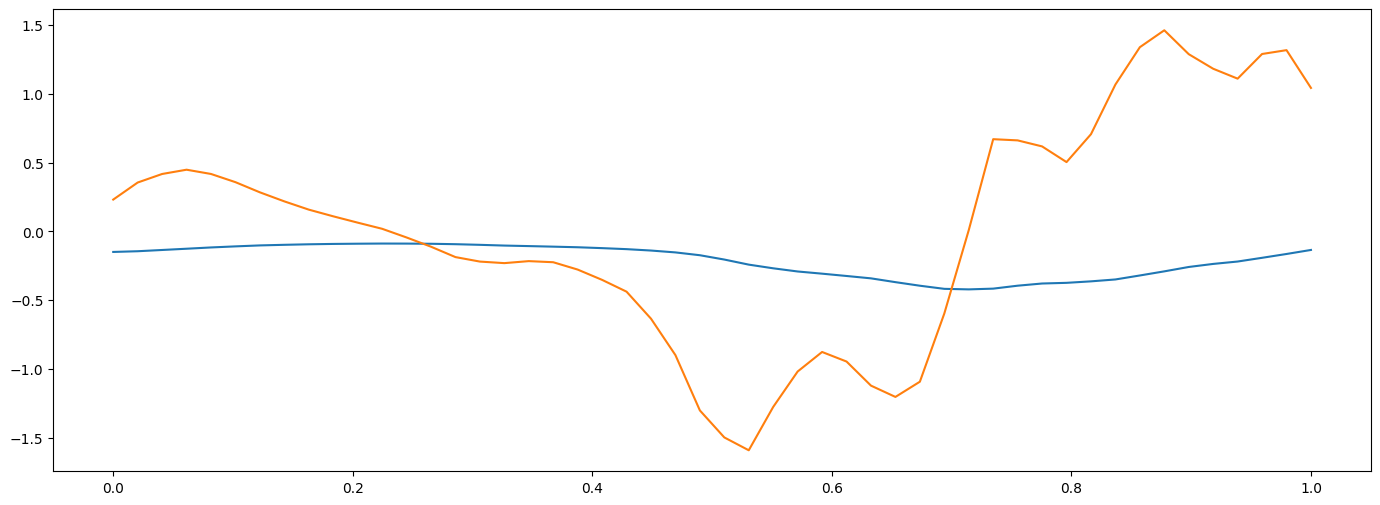

In [5]:
# expressive goal
fields = ["left_hip_pitch_joint_dof_pos", "left_hip_pitch_joint_dof_vel"]

fig, axes = plt.subplots(1, 1, figsize=(17, 6), sharex=True)

frame_num = int(ref_motion_cfg.ref_length_s/0.02)
time = np.linspace(0, ref_motion_cfg.ref_length_s, frame_num)
axes=[axes]
idx=0
axes[idx].plot(time, list_data[0],label="pos")
axes[idx].plot(time, list_data[1],label="vel")
axes[idx].plot(time, velocities,label="cal_vel")
axes[idx].plot(time, velocities2,label="cal_vel2")
axes[idx].grid(True)
axes[idx].legend()
plt.show()



2025-12-21 19:18:43,169 - motion_loader - INFO - Data will be loaded on device: cpu
2025-12-21 19:18:43,170 - motion_loader - INFO - Loading 1 motion files
2025-12-21 19:18:43,170 - motion_loader - INFO - Processing motion file 1/1: /home/thomas/workspace/lumos_ws/st_gym/third_party/motions/nix2/pkl/CMU_85_01_webster_op_1_247.pkl
2025-12-21 19:18:43,171 - motion_loader - INFO - Loaded trajectory with 246 frames (duration: 0.0333s per frame)
2025-12-21 19:18:43,171 - motion_loader - INFO - Selected frames 0 to 246 (246 frames total)
2025-12-21 19:18:43,174 - motion_loader - INFO - Trajectory duration: 8.17s
2025-12-21 19:18:43,175 - motion_loader - INFO - Preloading reference motion sequences
2025-12-21 19:18:43,175 - motion_loader - WARNING - Will depression augment_frame_num in the future, please use clip_frame_num
2025-12-21 19:18:43,175 - motion_loader - INFO - Preloading 1 trajectories with 408 frames each
2025-12-21 19:18:43,183 - motion_loader - INFO - Preloaded tensor shape: tor

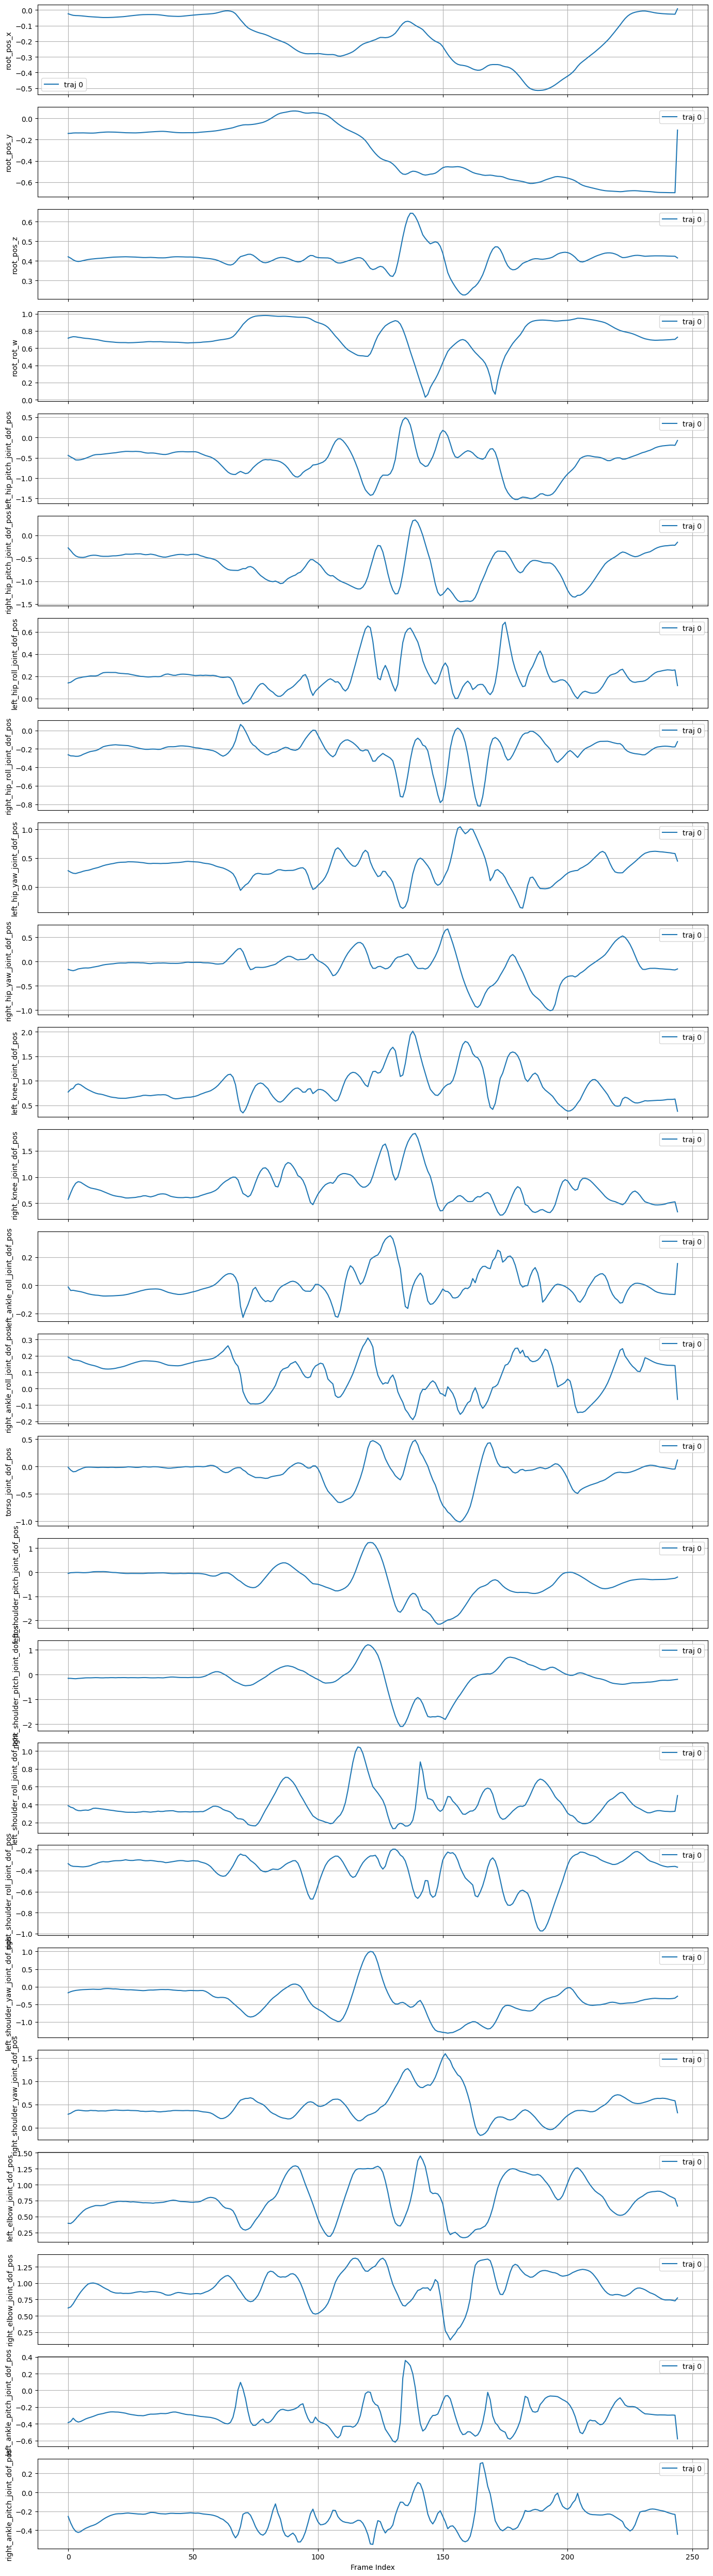

In [8]:
# Visualize selected data
import matplotlib.pyplot as plt
import itertools

def plot_ref_motion_trajectories(ref_motion, fields, start=0, end=50):
    """
    Plot selected fields of multiple trajectories in ref_motion.

    Args:
        ref_motion: An object with `trajectory_fields` and `trajectories` list of numpy arrays.
        fields (list[str]): List of field names to plot (must be in `ref_motion.trajectory_fields`).
        start (int): Start frame index.
        end (int): End frame index (exclusive).
    """
    # Get field indices
    index = [ref_motion.trajectory_fields.index(key) for key in fields]

    # Create subplots
    fig, axes = plt.subplots(len(fields), 1, figsize=(14,  2* len(fields)), sharex=True)
    if len(fields) == 1:
        axes = [axes]

    # Line style cycle
    linestyles = ["-", "--", "-.", ":", (0, (3, 5, 1, 5))]
    linestyle_cycle = itertools.cycle(linestyles)

    # Plot each trajectory
    for traj_idx, traj in enumerate(ref_motion.trajectories):
        linestyle = next(linestyle_cycle)
        data = traj[start:end, index]

        for i, field in enumerate(fields):
            axes[i].plot(
                data[:, i],
                label=f"traj {traj_idx}",
                linestyle=linestyle
            )
            axes[i].set_ylabel(field)
            axes[i].grid(True)
            axes[i].legend()

    axes[-1].set_xlabel("Frame Index")
    plt.tight_layout()
    plt.show()

ref_motion_cfg.motion_files=os.getenv("HOME")+"/workspace/lumos_ws/st_gym/third_party/motions/nix2/pkl/CMU*web*.pkl"

ref_motion_cfg.device="cpu"
ref_motion_cfg.ref_length_s=10
ref_motion = RefMotionLoader(ref_motion_cfg)

plot_ref_motion_trajectories(
    ref_motion,
     fields=["root_pos_x","root_pos_y","root_pos_z",
             "root_rot_w",
             "left_hip_pitch_joint_dof_pos", "right_hip_pitch_joint_dof_pos",
             "left_hip_roll_joint_dof_pos", "right_hip_roll_joint_dof_pos",
             "left_hip_yaw_joint_dof_pos", "right_hip_yaw_joint_dof_pos",
             "left_knee_joint_dof_pos", "right_knee_joint_dof_pos",
             "left_ankle_roll_joint_dof_pos","right_ankle_roll_joint_dof_pos",
             "torso_joint_dof_pos",
             "left_shoulder_pitch_joint_dof_pos", "right_shoulder_pitch_joint_dof_pos",
             "left_shoulder_roll_joint_dof_pos", "right_shoulder_roll_joint_dof_pos",
             "left_shoulder_yaw_joint_dof_pos", "right_shoulder_yaw_joint_dof_pos",
             "left_elbow_joint_dof_pos", "right_elbow_joint_dof_pos",
             "left_ankle_pitch_joint_dof_pos","right_ankle_pitch_joint_dof_pos",
            ],
    start=1,
    end=400
)



In [4]:
# Input: data.shape = (time_steps, variables)
def smooth(data, window_length=21, polyorder=2):
    """Smooth each variable independently using Savitzky-Golay filter."""
    if window_length % 2 == 0:
        window_length += 1  # Ensure odd window length
    return np.apply_along_axis(
        lambda x: savgol_filter(x, window_length, polyorder),
        axis=0,  # Apply along time axis (smooth each variable)
        arr=data
    )

def process_data(amp_data, process_map , traj_idx=0):
    processed_data = amp_data.trajectories[traj_idx].clone()
    for key, fields in process_map.items():
        if key == "reduce_mean":
            index=[amp_data.trajectory_fields.index(key) for key in fields]
            raw_data = amp_data.trajectories[traj_idx].clone()[:,index]
            plt.figure()
            plt.plot(raw_data,"r.-")
            mean = raw_data.mean(axis=0)
            print(f"mean: {mean}")
            new_data = raw_data - mean
            processed_data[:, index] = new_data
            plt.plot(new_data,"g")
            plt.grid()
        if key == "add_bias":
            bias = [value for key, value in fields.items()]
            index=[amp_data.trajectory_fields.index(key) for key in fields.keys()]
            raw_data = amp_data.trajectories[traj_idx].clone()[:,index]
            plt.figure()
            plt.plot(raw_data,"r.-",label="raw_data")
            bias = torch.tensor(bias)
            print(f"bias: {bias}")
            new_data = raw_data + bias
            processed_data[:, index] = new_data
            plt.plot(new_data,"g",label="processed_data")
            plt.grid()
        if key == "scale":
            scale = [value for key, value in fields.items()]
            index=[amp_data.trajectory_fields.index(key) for key in fields.keys()]
            raw_data = amp_data.trajectories[traj_idx].clone()[:,index]
            plt.figure("scale",figsize=(10,4))
            plt.plot(raw_data,"r.-")
            scale = torch.tensor(scale)
            print(f"bias: {scale}")
            new_data = raw_data*scale
            processed_data[:, index] = new_data
            plt.plot(new_data,"g")
            plt.grid()
        if key == "smooth":
            coef = [value for key, value in fields.items()]
            index=[amp_data.trajectory_fields.index(key) for key in fields.keys()]
            raw_data = amp_data.trajectories[traj_idx].clone()[:,index]
            plt.figure("smooth",figsize=(10,4))
            plt.plot(raw_data,"r",label="raw data")
            #coef = torch.tensor(coef)
            print(f"key: {key}, smooth coef: {coef}")
            new_data = smooth(raw_data, window_length=10, polyorder=1)
            processed_data[:, index] = torch.tensor(new_data)
            plt.plot(new_data,"g",label="prcoessed data")
            plt.title("Signal Smoothing Comparison", fontsize=12, pad=20)
            plt.xlabel("Time Steps", fontsize=10)
            plt.ylabel("Amplitude", fontsize=10)
            plt.legend()
            plt.grid()
            
            
    return processed_data


    
def save_processed_data(amp_data, processed_data):
    saved_data = {
        "LoopMode": "Wrap",
        "FrameDuration": amp_data.trajectory_frame_durations[0],
        "EnableCycleOffsetPosition": True,
        "EnableCycleOffsetRotation": True,
        "MotionWeight": 0.5,
        "Fields": amp_data.trajectory_fields,
        "Frames": processed_data.tolist()
    }
    # Define the path to the output file
    # Save the dictionary to a text file in JSON format
    raw_file_path = amp_data.trajectory_names[0]
    output_file_path = os.path.join(os.path.dirname(raw_file_path),"processed_"+os.path.basename(raw_file_path)+".txt")
    with open(output_file_path, 'w') as file:
        json.dump(saved_data, file, indent=4)
    print(f"Saved data to {output_file_path}")
    

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy import signal
import os

def calculate_trajectory_metrics(trajectories, fields, dt=1.0/60.0):
    """
    计算轨迹的各项指标
    """
    metrics = {}
    
    for traj_idx, traj in enumerate(trajectories):
        traj_metrics = {}
        
        # 计算位置连续性指标
        positions = traj[:, :len(fields)]  # 假设前len(fields)个是位置
        
        # 位置的一阶差分（速度）
        velocities = np.diff(positions, axis=0) / dt
        
        # 位置的二阶差分（加速度）
        accelerations = np.diff(velocities, axis=0) / dt
        
        # 位置连续性检查
        traj_metrics['position_continuity'] = {
            'max_discontinuity': np.max(np.abs(np.diff(positions, axis=0))),
            'mean_discontinuity': np.mean(np.abs(np.diff(positions, axis=0))),
            'has_nan': np.any(np.isnan(positions)),
            'has_inf': np.any(np.isinf(positions))
        }
        
        # 速度连续性检查
        traj_metrics['velocity_continuity'] = {
            'max_velocity': np.max(np.abs(velocities)),
            'mean_velocity': np.mean(np.abs(velocities)),
            'velocity_jerk': np.max(np.abs(np.diff(velocities, axis=0))) / dt
        }
        
        # 加速度连续性检查
        traj_metrics['acceleration_continuity'] = {
            'max_acceleration': np.max(np.abs(accelerations)),
            'mean_acceleration': np.mean(np.abs(accelerations))
        }
        
        # 关节位置范围检查
        traj_metrics['joint_limits'] = {
            'min_positions': np.min(positions, axis=0),
            'max_positions': np.max(positions, axis=0),
            'range_positions': np.ptp(positions, axis=0)
        }
        
        metrics[f'trajectory_{traj_idx}'] = traj_metrics
    
    return metrics

def plot_ref_motion_trajectories(ref_motion, fields, start=0, end=50, dt=1.0/60.0):
    """
    Plot selected fields of multiple trajectories in ref_motion with enhanced analysis.

    Args:
        ref_motion: An object with `trajectory_fields` and `trajectories` list of numpy arrays.
        fields (list[str]): List of field names to plot.
        start (int): Start frame index.
        end (int): End frame index (exclusive).
        dt (float): Time step between frames.
    """
    # Get field indices
    try:
        index = [ref_motion.trajectory_fields.index(key) for key in fields]
    except ValueError as e:
        print(f"Error: Field not found in trajectory_fields: {e}")
        print(f"Available fields: {ref_motion.trajectory_fields}")
        return
    
    # Calculate metrics
    print("Calculating trajectory metrics...")
    metrics = calculate_trajectory_metrics(ref_motion.trajectories, fields, dt)
    
    # Print metrics summary
    print("\n=== TRAJECTORY METRICS SUMMARY ===")
    for traj_key, traj_metrics in metrics.items():
        print(f"\n{traj_key}:")
        pos_cont = traj_metrics['position_continuity']
        vel_cont = traj_metrics['velocity_continuity']
        print(f"  Position - Max discontinuity: {pos_cont['max_discontinuity']:.6f}, "
              f"Has NaN: {pos_cont['has_nan']}, Has Inf: {pos_cont['has_inf']}")
        print(f"  Velocity - Max: {vel_cont['max_velocity']:.6f}, "
              f"Jerk: {vel_cont['velocity_jerk']:.6f}")
    
    # Create subplots - 3 rows: positions, velocities, accelerations
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    
    # Line style cycle
    linestyles = ["-", "--", "-.", ":", (0, (3, 5, 1, 5))]
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    time_axis = np.arange(start, end) * dt
    
    # Plot each trajectory
    for traj_idx, traj in enumerate(ref_motion.trajectories):
        if traj_idx >= len(colors):
            break
            
        color = colors[traj_idx % len(colors)]
        data = traj[start:end, index]
        
        # Calculate derivatives
        velocities = np.diff(data, axis=0, prepend=data[0:1]) / dt
        accelerations = np.diff(velocities, axis=0, prepend=velocities[0:1]) / dt
        
        # Plot positions
        for i, field in enumerate(fields):
            axes[0].plot(
                time_axis,
                data[:, i],
                label=f"{field} (traj {traj_idx})",
                color=color,
                alpha=0.7,
                linewidth=1.5
            )
        
        # Plot velocities (mean across joints)
        mean_velocity = np.mean(np.abs(velocities), axis=1)
        axes[1].plot(
            time_axis,
            mean_velocity,
            label=f"Mean Vel (traj {traj_idx})",
            color=color,
            linestyle='--',
            alpha=0.8
        )
        
        # Plot accelerations (mean across joints)
        mean_acceleration = np.mean(np.abs(accelerations), axis=1)
        axes[2].plot(
            time_axis,
            mean_acceleration,
            label=f"Mean Acc (traj {traj_idx})",
            color=color,
            linestyle=':',
            alpha=0.8
        )
    
    # Configure subplots
    axes[0].set_ylabel('Joint Positions', fontsize=12)
    axes[0].set_title('Reference Motion Trajectory Analysis', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    axes[1].set_ylabel('Mean Velocity', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    axes[2].set_ylabel('Mean Acceleration', fontsize=12)
    axes[2].set_xlabel('Time (s)', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Create detailed joint analysis plot
    plot_detailed_joint_analysis(ref_motion, fields, start, end, dt)
    
    return metrics

def plot_detailed_joint_analysis(ref_motion, fields, start=0, end=50, dt=1.0/60.0):
    """
    绘制详细的关节分析图
    """
    index = [ref_motion.trajectory_fields.index(key) for key in fields]
    
    # 按关节类型分组
    joint_groups = {
        'Hip Joints': ['hip_pitch', 'hip_roll', 'hip_yaw'],
        'Knee Joints': ['knee_joint'],
        'Ankle Joints': ['ankle_roll', 'ankle_pitch'],
        'Shoulder Joints': ['shoulder_pitch', 'shoulder_roll', 'shoulder_yaw'],
        'Elbow Joints': ['elbow_joint'],
        'Torso': ['torso_joint']
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    time_axis = np.arange(start, end) * dt
    
    for traj_idx, traj in enumerate(ref_motion.trajectories):
        if traj_idx >= 3:  # 限制显示的轨迹数量
            break
            
        data = traj[start:end, index]
        velocities = np.diff(data, axis=0, prepend=data[0:1]) / dt
        
        for group_idx, (group_name, joint_keywords) in enumerate(joint_groups.items()):
            if group_idx >= len(axes):
                break
                
            # 找到属于该组的关节
            group_indices = []
            for i, field in enumerate(fields):
                if any(keyword in field for keyword in joint_keywords):
                    group_indices.append(i)
            
            if group_indices:
                group_data = data[:, group_indices]
                group_velocities = velocities[:, group_indices]
                
                # 绘制位置范围
                pos_min = np.min(group_data, axis=1)
                pos_max = np.max(group_data, axis=1)
                axes[group_idx].fill_between(time_axis, pos_min, pos_max, 
                                           alpha=0.2, label=f'Traj {traj_idx} Range')
                axes[group_idx].plot(time_axis, np.mean(group_data, axis=1), 
                                   linewidth=2, label=f'Traj {traj_idx} Mean')
                
                axes[group_idx].set_title(f'{group_name}', fontweight='bold')
                axes[group_idx].set_ylabel('Position')
                axes[group_idx].grid(True, alpha=0.3)
                axes[group_idx].legend()
    
    plt.tight_layout()
    plt.show()

def check_trajectory_quality(metrics, threshold_dict=None):
    """
    检查轨迹质量
    """
    if threshold_dict is None:
        threshold_dict = {
            'max_position_discontinuity': 0.1,
            'max_velocity': 10.0,
            'max_jerk': 100.0
        }
    
    print("\n=== TRAJECTORY QUALITY CHECK ===")
    
    for traj_key, traj_metrics in metrics.items():
        print(f"\nChecking {traj_key}:")
        
        pos_cont = traj_metrics['position_continuity']
        vel_cont = traj_metrics['velocity_continuity']
        
        # 检查位置连续性
        if pos_cont['max_discontinuity'] > threshold_dict['max_position_discontinuity']:
            print(f"  ⚠️  Position discontinuity too high: {pos_cont['max_discontinuity']:.6f}")
        else:
            print(f"  ✅ Position continuity: OK")
            
        if pos_cont['has_nan']:
            print(f"  ❌ Contains NaN values!")
        else:
            print(f"  ✅ No NaN values")
            
        if pos_cont['has_inf']:
            print(f"  ❌ Contains Inf values!")
        else:
            print(f"  ✅ No Inf values")
        
        # 检查速度
        if vel_cont['max_velocity'] > threshold_dict['max_velocity']:
            print(f"  ⚠️  Velocity too high: {vel_cont['max_velocity']:.6f}")
        else:
            print(f"  ✅ Velocity: OK")
            
        # 检查加加速度（jerk）
        if vel_cont['velocity_jerk'] > threshold_dict['max_jerk']:
            print(f"  ⚠️  Jerk too high: {vel_cont['velocity_jerk']:.6f}")
        else:
            print(f"  ✅ Jerk: OK")

# 使用示例
if __name__ == "__main__":
    # 您的原有配置
    ref_motion_cfg.motion_files = os.getenv("HOME") + "/workspace/lumos_ws/st_gym/third_party/motions/nix2/pkl/CMU*web*.pkl"
    ref_motion_cfg.device = "cpu"
    ref_motion_cfg.ref_length_s = 1.0
    ref_motion = RefMotionLoader(ref_motion_cfg)
    
    # 定义要分析的字段
    analysis_fields = [
        "root_pos_x", "root_pos_y", "root_pos_z",
        "left_hip_pitch_joint_dof_pos", "right_hip_pitch_joint_dof_pos",
        "left_hip_roll_joint_dof_pos", "right_hip_roll_joint_dof_pos", 
        "left_hip_yaw_joint_dof_pos", "right_hip_yaw_joint_dof_pos",
        "left_knee_joint_dof_pos", "right_knee_joint_dof_pos",
        "left_ankle_roll_joint_dof_pos", "right_ankle_roll_joint_dof_pos",
        "torso_joint_dof_pos",
        "left_shoulder_pitch_joint_dof_pos", "right_shoulder_pitch_joint_dof_pos",
        "left_shoulder_roll_joint_dof_pos", "right_shoulder_roll_joint_dof_pos",
        "left_shoulder_yaw_joint_dof_pos", "right_shoulder_yaw_joint_dof_pos", 
        "left_elbow_joint_dof_pos", "right_elbow_joint_dof_pos",
        "left_ankle_pitch_joint_dof_pos", "right_ankle_pitch_joint_dof_pos",
    ]
    
    # 运行分析
    metrics = plot_ref_motion_trajectories(
        ref_motion,
        fields=analysis_fields,
        start=1,
        end=400,
        dt=1.0/30.0  # 假设60Hz采样
    )
    
    # 检查轨迹质量
    check_trajectory_quality(metrics)

2025-12-21 19:19:28,883 - motion_loader - INFO - Data will be loaded on device: cpu
2025-12-21 19:19:28,884 - motion_loader - INFO - Loading 1 motion files
2025-12-21 19:19:28,884 - motion_loader - INFO - Processing motion file 1/1: /home/thomas/workspace/lumos_ws/st_gym/third_party/motions/nix2/pkl/CMU_85_01_webster_op_1_247.pkl
2025-12-21 19:19:28,885 - motion_loader - INFO - Loaded trajectory with 246 frames (duration: 0.0333s per frame)
2025-12-21 19:19:28,885 - motion_loader - INFO - Selected frames 0 to 246 (246 frames total)
2025-12-21 19:19:28,890 - motion_loader - INFO - Trajectory duration: 8.17s
2025-12-21 19:19:28,890 - motion_loader - INFO - Preloading reference motion sequences
2025-12-21 19:19:28,890 - motion_loader - WARNING - Will depression augment_frame_num in the future, please use clip_frame_num
2025-12-21 19:19:28,891 - motion_loader - INFO - Preloading 1 trajectories with 50 frames each
2025-12-21 19:19:28,897 - motion_loader - INFO - Preloaded tensor shape: torc

Calculating trajectory metrics...


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim = None, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis


In [5]:
# loading data as pandas dataframe
import numpy as np
traj_idx=0
all_pd_data = pd.DataFrame(data=amp_data.trajectories[traj_idx],columns=amp_data.trajectory_fields)
all_pd_data["time"] = np.linspace(0,amp_data.trajectory_lens[traj_idx],amp_data.trajectories[traj_idx].shape[0])
all_pd_data.head()

root_pos_x  root_pos_y  root_pos_z  root_rot_x  root_rot_y  root_rot_z  \
0   -0.419833    0.055409    1.074324   -0.111689   -0.019550   -0.005996   
1   -0.419980    0.055580    1.074148   -0.111102   -0.019846   -0.009399   
2   -0.419873    0.055842    1.074375   -0.110751   -0.020422   -0.011840   
3   -0.418533    0.053916    1.074501   -0.111230   -0.020424   -0.010511   
4   -0.416347    0.051494    1.074332   -0.109559   -0.021707   -0.010635   

   root_rot_w  root_vel_x  root_vel_y  root_vel_z  ...  \
0    0.993533    0.000000    0.000000    0.000000  ...   
1    0.993566   -0.007306    0.008551   -0.008768  ...   
2    0.993568    0.005335    0.013072    0.011319  ...   
3    0.993529    0.066997   -0.096297    0.006324  ...   
4    0.993686    0.109303   -0.121077   -0.008470  ...   

   right_wrist_yaw_joint_dof_vel  right_wrist_pitch_joint_dof_vel  \
0                            0.0                              0.0   
1                            0.0                              0.0   
2                            0.0                              0.0   
3                            0.0                              0.0   
4                            0.0                              0.0   

   right_wrist_roll_joint_dof_vel  left_elbow_link_x  left_elbow_link_y  \
0                             0.0          -0.017423           0.280218   
1                             0.0          -0.015904           0.280456   
2                             0.0          -0.014249           0.281285   
3                             0.0          -0.014581           0.282097   
4                             0.0          -0.014212           0.282751   

   left_elbow_link_z  right_elbow_link_x  right_elbow_link_y  \
0          -0.019160            0.276553           -0.253768   
1          -0.018845            0.275765           -0.253033   
2          -0.018671            0.274164           -0.253020   
3          -0.018996            0.274707           -0.250631   
4          -0.018159            0.273510           -0.250531   

   right_elbow_link_z  time  
0            0.325280  0.00  
1            0.323458  0.02  
2            0.322529  0.04  
3            0.321769  0.06  
4            0.320818  0.08  

[5 rows x 74 columns]

In [105]:
#载入pyg库
import pygwalker as pyg
#载入我们之前通过pandas处理好的告警数据
pyg.walk(all_pd_data,
         hideDataSourceConfig=True,
         themekey="vega",
         dark="media",
        #kernel_computation=True, 
         env="Jupyter")

In [107]:
import pandas as pd
import streamlit as st
from pygwalker.api.streamlit import StreamlitRenderer

uploaded_file = st.file_uploader("Your data file")
if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    pyg_app = StreamlitRenderer(df)
    pyg_app.explorer()

2025-03-27 16:27:06.373 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 16:27:06.375 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 16:27:06.375 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 16:27:06.376 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 16:27:06.376 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 16:27:06.385 
  command:

    streamlit run /home/admin-1/miniconda3/envs/isaaclab2.0/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-03-27 16:27:06.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [24]:
amp_data.trajectories[0][100:1000].shape

torch.Size([802, 73])

In [57]:
data.shape

torch.Size([138, 2])

2025-05-09 11:40:15,102 - motion_loader - INFO - [Dataset Info] start to reading /home/thomas/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/txt/CMU_CMU_08_08_03_poses.txt
2025-05-09 11:40:15,105 - motion_loader - INFO - [Dataset Info] Load /home/thomas/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/txt/CMU_CMU_08_08_03_poses.txt
2025-05-09 11:40:15,106 - motion_loader - INFO - [Dataset Info] It has 181 frames.
2025-05-09 11:40:15,106 - motion_loader - INFO - [Dataset Info] Select 171 frames from frame_begin is 10 and frame_end is 181.
2025-05-09 11:40:15,110 - motion_loader - INFO - [Dataset Info] Select 3.4 s motion from the trajectory.
2025-05-09 11:40:15,111 - motion_loader - INFO - [Dataset Info] start to reading /home/thomas/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/txt/CMU_CMU_07_07_05_poses.txt
2025-05-09 11:40:15,114 - motion_loader - INFO - [Dataset Info] Load /home/thomas/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/txt/CMU_CMU_07_07_05_poses.txt
2

bias: tensor([0.1000])
key: smooth, smooth coef: [[5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2], [5, 2]]
Saved data to /home/thomas/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/txt/processed_CMU_CMU_08_08_03_poses.txt


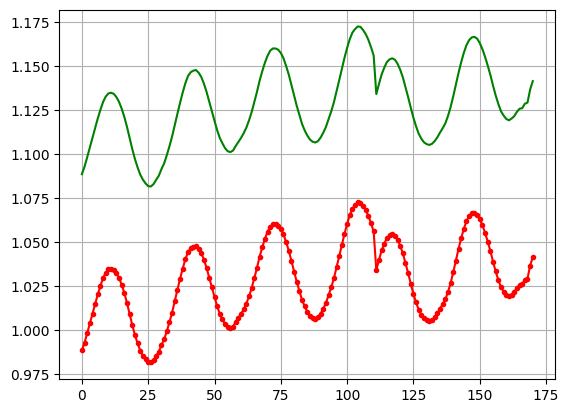

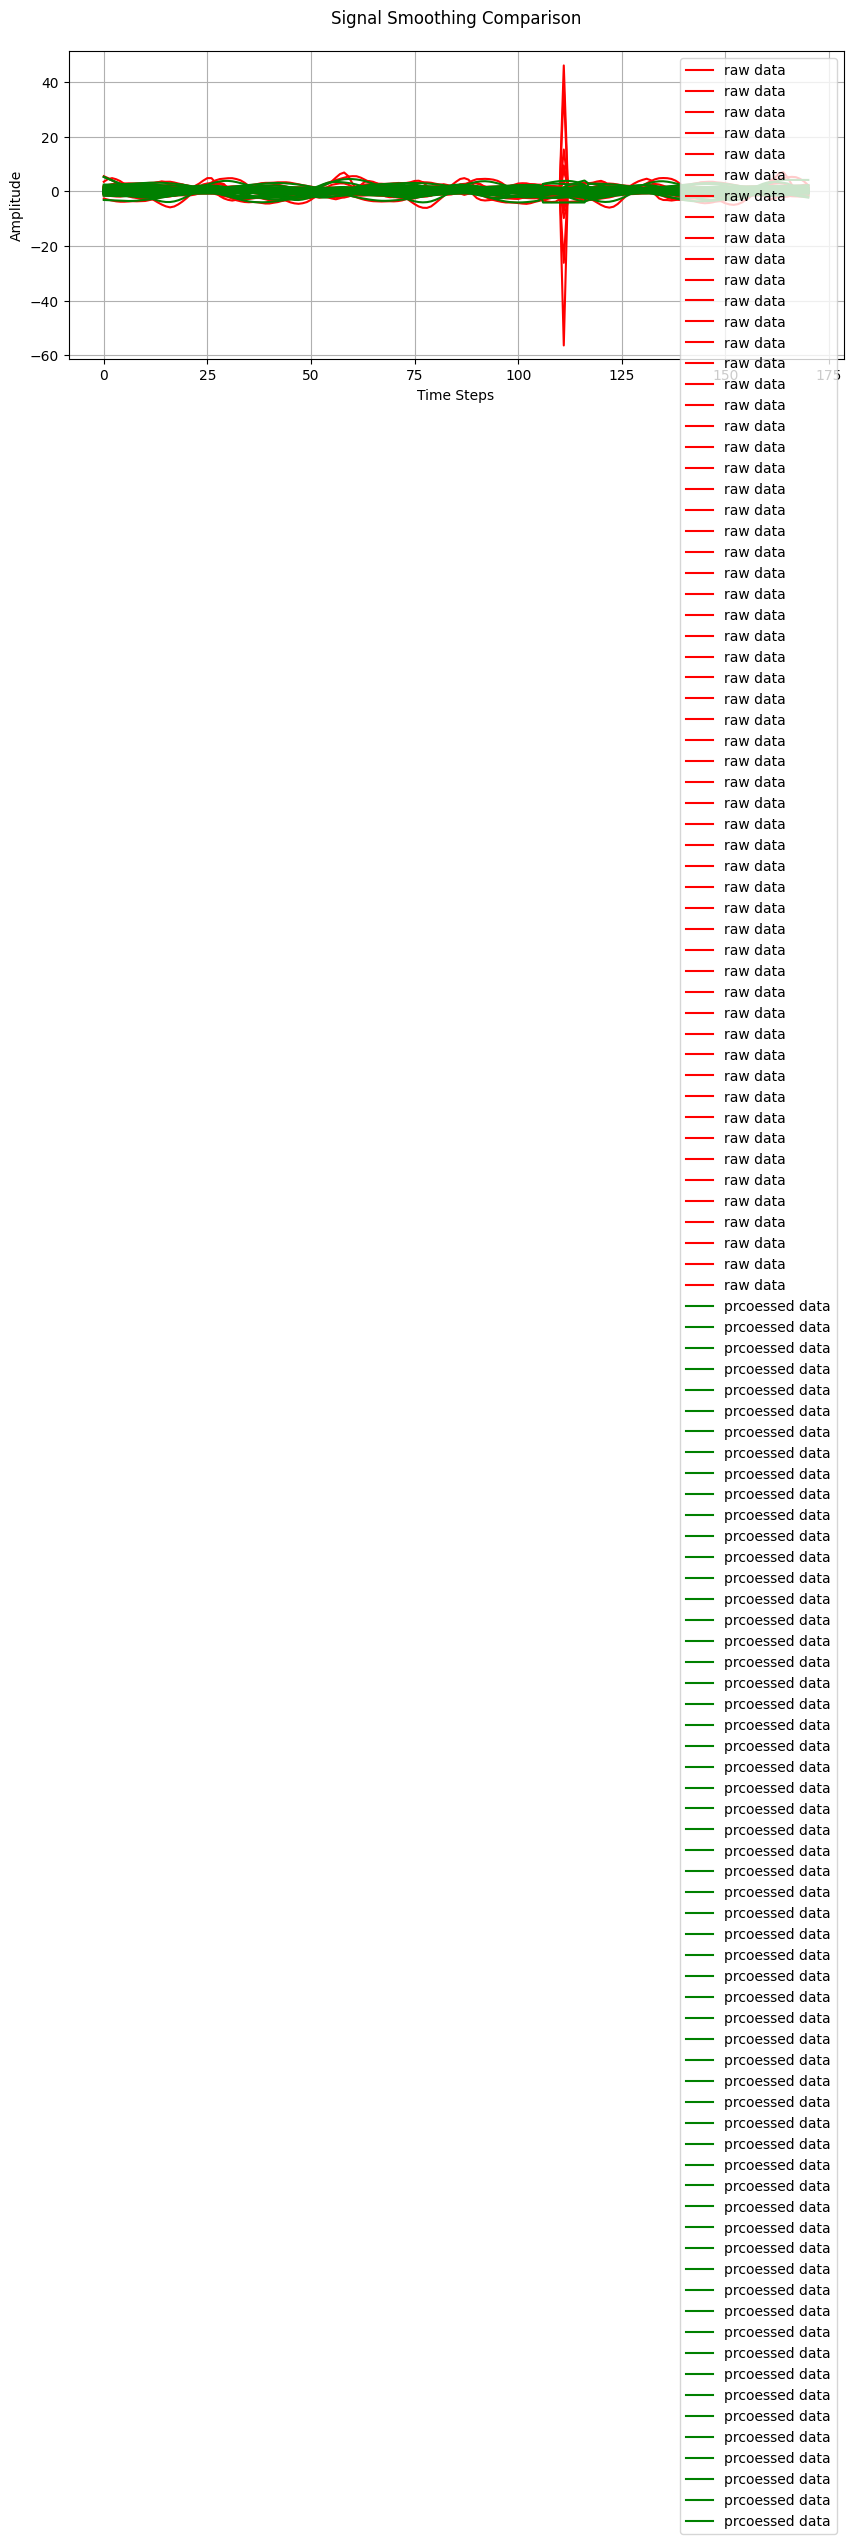

In [30]:
traj_idx=0
process_map={"reduce_mean": fields, "add_bias":{"left_shoulder_roll_joint_dof_pos":0.1, "right_shoulder_roll_joint_dof_pos":-0.1},
             "scale":{"left_hip_roll_joint_dof_pos": 0.2, "right_hip_roll_joint_dof_pos": 0.2,"left_hip_roll_joint_dof_vel": 0.2, "right_hip_roll_joint_dof_vel": 0.2}}

process_map={ 
             
             "add_bias":{"root_pos_z":0.1},
             "smooth":{
                 "root_pos_x":[5,2],
                 "root_pos_y":[5,2],
                 "root_pos_z":[5,2],
            
                 "root_vel_x":[5,2],
                 "root_vel_y":[5,2],
                 "root_vel_z":[5,2],
                 "root_ang_vel_x":[5,2],
                 "root_ang_vel_y":[5,2],
                 "root_ang_vel_z":[5,2],
                 
                 "left_hip_pitch_joint_dof_vel":[5,2],
                 "right_hip_pitch_joint_dof_vel":[5,2],
                 "left_hip_roll_joint_dof_vel":[5,2],
                 "right_hip_roll_joint_dof_vel":[5,2],
                 "left_hip_yaw_joint_dof_vel":[5,2],
                 "right_hip_yaw_joint_dof_vel":[5,2],
                 "left_knee_joint_dof_vel":[5,2],
                 "right_knee_joint_dof_vel":[5,2],
                 "left_ankle_pitch_joint_dof_vel":[5,2],
                 "right_ankle_pitch_joint_dof_vel":[5,2],
                 "left_ankle_roll_joint_dof_vel":[5,2],
                 "right_ankle_roll_joint_dof_vel":[5,2],
                 "left_shoulder_pitch_joint_dof_vel":[5,2],
                 "right_shoulder_pitch_joint_dof_vel":[5,2],
                 "left_shoulder_roll_joint_dof_vel":[5,2],
                 "right_shoulder_roll_joint_dof_vel":[5,2],
                 "left_shoulder_yaw_joint_dof_vel":[5,2],
                 "right_shoulder_yaw_joint_dof_vel":[5,2],
                 "left_elbow_joint_dof_vel":[5,2],
                 "right_elbow_joint_dof_vel":[5,2],
                 "left_wrist_yaw_joint_dof_vel":[5,2],
                 "right_wrist_yaw_joint_dof_vel":[5,2],
                 "left_wrist_pitch_joint_dof_vel":[5,2],
                 "right_wrist_pitch_joint_dof_vel":[5,2],
                 "torso_joint_dof_vel":[5,2],
                 
                 "left_hip_pitch_joint_dof_pos":[5,2],
                 "right_hip_pitch_joint_dof_pos":[5,2],
                 "left_hip_roll_joint_dof_pos":[5,2],
                 "right_hip_roll_joint_dof_pos":[5,2],
                 "left_hip_yaw_joint_dof_pos":[5,2],
                 "right_hip_yaw_joint_dof_pos":[5,2],
                 "left_knee_joint_dof_pos":[5,2],
                 "right_knee_joint_dof_pos":[5,2],
                 "left_ankle_pitch_joint_dof_pos":[5,2],
                 "right_ankle_pitch_joint_dof_pos":[5,2],
                 "left_ankle_roll_joint_dof_pos":[5,2],
                 "right_ankle_roll_joint_dof_pos":[5,2],
                 "left_shoulder_pitch_joint_dof_pos":[5,2],
                 "right_shoulder_pitch_joint_dof_pos":[5,2],
                 "left_shoulder_roll_joint_dof_pos":[5,2],
                 "right_shoulder_roll_joint_dof_pos":[5,2],
                 "left_shoulder_yaw_joint_dof_pos":[5,2],
                 "right_shoulder_yaw_joint_dof_pos":[5,2],
                 "left_elbow_joint_dof_pos":[5,2],
                 "right_elbow_joint_dof_pos":[5,2],
                 "left_wrist_yaw_joint_dof_pos":[5,2],
                 "right_wrist_yaw_joint_dof_pos":[5,2],
                 "left_wrist_pitch_joint_dof_pos":[5,2],
                 "right_wrist_pitch_joint_dof_pos":[5,2],
                 "torso_joint_dof_pos":[5,2],
                      }
}
amp_data_cfg.motion_files=glob.glob(os.getenv("HOME")+"/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/txt/*.txt")
amp_data = AMPLoader(**amp_data_cfg)

processed_data = process_data(amp_data, process_map)
save_processed_data(amp_data, processed_data)


In [34]:
ss=[-1,2]
ll=torch.tensor(ss)

In [15]:
index=[amp_data.trajectory_fields.index(key) for key in fields]
processed_data = amp_data.trajectories[traj_idx].clone()
raw_data = processed_data[:, index]


In [50]:
print(os.path.dirname(motion_files[0]),os.path.basename(motion_files[0]))
print(amp_data.trajectory_frame_durations[0])
#print(amp_data.trajectory_fields)
print(amp_data.trajectory_names)

/home/thomas/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/v1/singles lus1_demo_data(1).txt
0.016666666666666666
['/home/thomas/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/v1/singles/lus1_demo_data(1)']


In [13]:
#saving process data into a file
# Assuming saved_data is a dictionary
save_processed_data(amp_data, processed_data)


Saved data to /home/thomas/workspace/lumos_ws/humanoid_demo_retarget/data/lus1/v1/singles/processed_processed_0-HumanEva_S2_Gestures_3_poses.txt


[Datset Info] Motion files: 
['/home/admin-1/workspace/kepler_ws/KeplerRobot/datasets/motion_files/k1/MCU/02_1/7_walk_saved_data.txt']
[Dataset Info] start to reading /home/admin-1/workspace/kepler_ws/KeplerRobot/datasets/motion_files/k1/MCU/02_1/7_walk_saved_data.txt
[Dataset Info] Load /home/admin-1/workspace/kepler_ws/KeplerRobot/datasets/motion_files/k1/MCU/02_1/7_walk_saved_data.txt
[Dataset Info] It has 101 frames.
[Dataset Info] Select 101 frames.
[Dataset Info] Select 3.3333333333333335 s motion from the trajectory.
[Dataset Info] Preloading data into self.preloaded_s and self.preloaded_s_next
[Dataset Info] self.preloaded_s dim are 1 and torch.Size([101, 82])
 Trajectory number: 1
mean: tensor([0.0303, 0.0300])
bias: tensor([ 0.1000, -0.1000])
bias: tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.4000, 0.4000, 0.4000, 0.4000])
Saved data to /home/admin-1/workspace/kepler_ws/KeplerRobot/datasets/motion_files/k1/MCU/02_1/1_7_walk_saved_data.txt


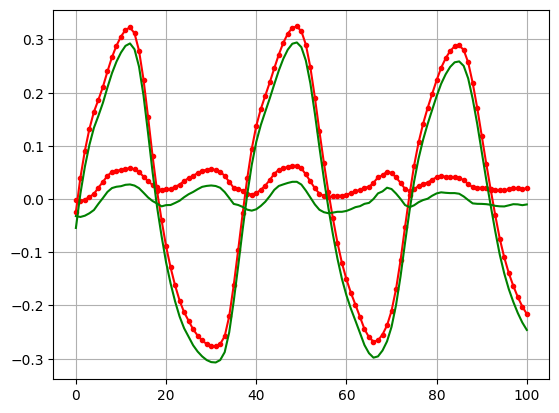

In [ ]:
#Process data in batch

data_folder = os.getenv("HOME") + "/workspace/kepler_ws/KeplerRobot/datasets/motion_files/k1/MCU/02_1/"
data_file = "7_walk_saved_data.txt"

amp_data = load_amp_data(data_folder, data_file)
fields = ["waist_roll_joint_dof_pos","waist_yaw_joint_dof_pos"]
process_map={"reduce_mean": fields, "add_bias":{"left_shoulder_roll_joint_dof_pos":0.1, "right_shoulder_roll_joint_dof_pos":-0.1},
             "scale":{"left_hip_yaw_joint_dof_pos": 0.2, "right_hip_yaw_joint_dof_pos": 0.2,"left_hip_yaw_joint_dof_vel": 0.2, "right_hip_yaw_joint_dof_vel": 0.2,
                     "left_hip_roll_joint_dof_pos": 0.4, "right_hip_roll_joint_dof_pos": 0.4,"left_hip_roll_joint_dof_vel": 0.4, "right_hip_roll_joint_dof_vel": 0.4
                     
                     }}
processed_data = process_data(amp_data, process_map)
output_file_path = os.path.join(data_folder, "1_"+data_file)
save_processed_data(amp_data, processed_data, output_file_path)